In this notebook I will give an overview on how the pepskit code handles infinite peps.

In [1]:
using MPSKit,PEPSKit,TensorKit,OptimKit,Plots

The infinite peps constructor takes a 2 dimensional array of peps tensors. The following creates a 2 by 2 unit cell peps.

In [2]:
data = map(Iterators.product(1:2,1:2)) do (i,j)
    TensorMap(rand,ComplexF64,ℂ^2*ℂ^2*(ℂ^2)'*(ℂ^2)',(ℂ^2)')
end

peps = InfPEPS(data);

To actually calculate anything meaningful, we need access to the peps environments. This object can be created by calling params, and PEPSKit provides some useful methods to access the boundary tensors.

One minor caveat, params() also normalizes the peps tensors behind the scenes. It's much easier to work with our algorithms if the peps is normalized...

In [3]:
env = params(peps);
codomain(AC(env,North,2,2)) ← domain(AC(env,North,2,2))

vumps @iteration 1 galerkin = 3.923489075059065
vumps @iteration 1 galerkin = 4.8288950596799545
vumps @iteration 1 galerkin = 3.5470175021761414
vumps @iteration 1 galerkin = 2.289692105401795
vumps @iteration 2 galerkin = 0.05185116518021401
vumps @iteration 2 galerkin = 0.07123250940578585
vumps @iteration 2 galerkin = 0.11922284763590416
vumps @iteration 2 galerkin = 0.07865376201065356
vumps @iteration 3 galerkin = 0.0013253199135754854
vumps @iteration 3 galerkin = 0.0012003173883676345
vumps @iteration 3 galerkin = 0.001333908035180336
vumps @iteration 3 galerkin = 0.0045229139467320685
vumps @iteration 4 galerkin = 1.867793350057598e-5
vumps @iteration 4 galerkin = 7.925331695753705e-6
vumps @iteration 4 galerkin = 9.092612643291823e-6
vumps @iteration 5 galerkin = 1.3077524836068487e-7
vumps @iteration 5 galerkin = 3.202108501875381e-7
vumps @iteration 5 galerkin = 1.1903084809691781e-7
vumps @iteration 4 galerkin = 0.00015665745252216437
vumps @iteration 6 galerkin = 4.337777

(ℂ^1 ⊗ ℂ^2 ⊗ (ℂ^2)') ← ℂ^1

As you can see, by default the environment tensors are trivial chi = 1. There is no easy way to change this, at the moment you have to make use of the MPSKit finalize - changebonds machinery.

In [4]:
function bound_finalize(iter,state,ham,pars)
    maxD = 10;
    
    # check every virtual bond dimension and see if it's larger then maxD
    bigenough = reduce((a,(i,j))-> a && dim(virtualspace(state,i,j))>=maxD,
        Iterators.product(1:size(state,1),1:size(state,2)),init=true)
    
    if !bigenough 
        (state,pars) = changebonds(state,ham,OptimalExpand(trscheme=truncdim(3)),pars)
    end
    
    return (state,pars,true)
end
env = params(peps,alg=Vumps(verbose=false,finalize=bound_finalize))

codomain(AC(env,North,2,2)) ← domain(AC(env,North,2,2))

(ℂ^10 ⊗ ℂ^2 ⊗ (ℂ^2)') ← ℂ^10

It is now very easy to calculate the norm of our infinite mps in a bunch of different ways

In [5]:
@tensor fp1RL(env,North,1,1)[1,2,3,4]*fp1LR(env,South,0,1)[4,2,3,1]

0.9999996827846406 + 5.712437886954385e-12im

In [6]:
@tensor fp0RL(env,East,1,1)[1,2]*fp0LR(env,West,0,2)[2,1]

0.9999999999999992 - 3.3306690738754696e-16im

In [7]:
@tensor fp1LR(env,North,2,2)[1,2,3,4]*
        corner(env,NorthEast,2,2)[4,5]*
        fp1LR(env,East,2,2)[5,6,7,8]*
        corner(env,SouthEast,2,2)[8,9]*
        fp1LR(env,South,2,2)[9,10,11,12]*
        corner(env,SouthWest,2,2)[12,13]*
        fp1LR(env,West,2,2)[13,14,15,16]*
        corner(env,NorthWest,2,2)[16,1]*
        peps[2,2][14,10,6,2,17]*
        conj(peps[2,2][15,11,7,3,17])

1.0 + 2.2881125446884506e-12im

Anyway, this probably makes very little sense unless you know the ins and outs already. It should clarify why things like measuring expectation values require passing in the environment object itself :

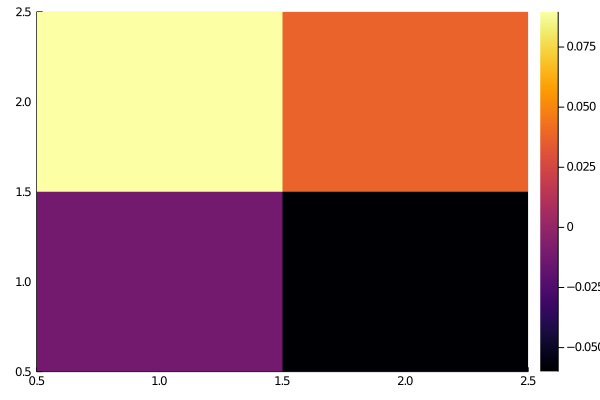

In [8]:
sz = TensorMap([1 0;0 -1],ℂ^2,ℂ^2)
heatmap(real.(expectation_value(env,sz)))

In [9]:
ham = nonsym_nn_xxz_ham();
expectation_value(env,ham)

1.93459844274404 + 4.026358360521941e-12im

To numerically approximate the gradient, we can use a number of different techniques. One such approximation is known as the channel approximation. To calculate these channels, you can simply call

In [10]:
chan = channels(env,ham);

While this object isn't very exciting in and of itself, we can use it to get the effective hamiltonian and gram matrix:

In [11]:
(H_eff,N_eff) = PEPSKit.effectivehn(chan,2,2)
codomain(H_eff) ← domain(H_eff)

(ℂ^2 ⊗ ℂ^2 ⊗ (ℂ^2)' ⊗ (ℂ^2)' ⊗ ℂ^2) ← (ℂ^2 ⊗ ℂ^2 ⊗ (ℂ^2)' ⊗ (ℂ^2)' ⊗ ℂ^2)

Let's calculate the gradient : 

In [12]:
v = permute(peps[2,2],(1,2,3,4,5))
gradient = H_eff*v - dot(v,H_eff*v)*N_eff*v
norm(gradient)

0.22636326524072573

The energy can also be minimized using algorithms from another package - OptimKit.

In [13]:
optalg = LBFGS(linesearch = HagerZhangLineSearch(ϵ = 1e-3,verbosity=0),maxiter=500,verbosity=20,gradtol=1e-2)

(gs_state,gs_chan,delta) = find_groundstate(peps,ham,optalg,chan);

┌ Info: LBFGS: initializing with f = 0.483649610683, ‖∇f‖ = 1.2980e+00
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:35
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: trying stepsize 5.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 6.921385658635782e-11


┌ Info: trying stepsize 25.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: trying stepsize 16.852668419513474
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter    1: f = 0.091738472699, ‖∇f‖ = 4.9034e+00, α = 1.69e+01, m = 0, nfg = 4
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter    2: f = -0.363170882352, ‖∇f‖ = 2.9200e+00, α = 1.00e+00, m = 1, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter    3: f = -0.443678013743, ‖∇f‖ = 2.4333e+00, α = 1.00e+00, m = 2, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/

vumps didn't converge 4.071223141168044e-12


┌ Info: LBFGS: iter    7: f = -0.582879747788, ‖∇f‖ = 1.7162e+00, α = 1.00e+00, m = 6, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter    8: f = -0.615550664307, ‖∇f‖ = 1.2294e+00, α = 1.00e+00, m = 7, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter    9: f = -0.645382143998, ‖∇f‖ = 7.8948e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 7.856192713781994e-12


┌ Info: LBFGS: iter   10: f = -0.653066930877, ‖∇f‖ = 4.4889e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 4.6096373371320124e-11


┌ Info: LBFGS: iter   11: f = -0.656731441242, ‖∇f‖ = 2.2611e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 1.4695800338402562e-12


┌ Info: LBFGS: iter   12: f = -0.657680767949, ‖∇f‖ = 1.5312e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 4.534825084682126e-12


┌ Info: LBFGS: iter   13: f = -0.658316173032, ‖∇f‖ = 1.5411e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   14: f = -0.659072899574, ‖∇f‖ = 9.9086e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   15: f = -0.659577454053, ‖∇f‖ = 1.1592e-01, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   16: f = -0.659784870829, ‖∇f‖ = 5.1559e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76


vumps didn't converge 1.8116088168245755e-12


┌ Info: LBFGS: iter   18: f = -0.659884593898, ‖∇f‖ = 2.8788e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 1.0573683334618295e-10


┌ Info: LBFGS: iter   19: f = -0.659935516047, ‖∇f‖ = 3.5305e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19


vumps didn't converge 2.0997115148591504e-11


┌ Info: LBFGS: iter   20: f = -0.659997861482, ‖∇f‖ = 5.2177e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   21: f = -0.660036928544, ‖∇f‖ = 3.6744e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   22: f = -0.660058080004, ‖∇f‖ = 1.7751e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   23: f = -0.660073739141, ‖∇f‖ = 1.7862e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76


vumps didn't converge 1.0876675836269989e-10


┌ Info: LBFGS: iter   29: f = -0.660185154908, ‖∇f‖ = 1.8356e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   30: f = -0.660206940237, ‖∇f‖ = 2.3645e-02, α = 1.00e+00, m = 8, nfg = 1
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: trying stepsize 0.4640014715057362
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   31: f = -0.660216048621, ‖∇f‖ = 2.9736e-02, α = 4.64e-01, m = 8, nfg = 2
└ @ OptimKit /home/maarten/.julia/packages/OptimKit/k1BUJ/src/lbfgs.jl:76
┌ Info: trying stepsize 1.0
└ @ PEPSKit /home/maarten/PEPSKit.jl/src/algorithms/groundstate/optimhook.jl:19
┌ Info: LBFGS: iter   32: f = -0.660231475553,

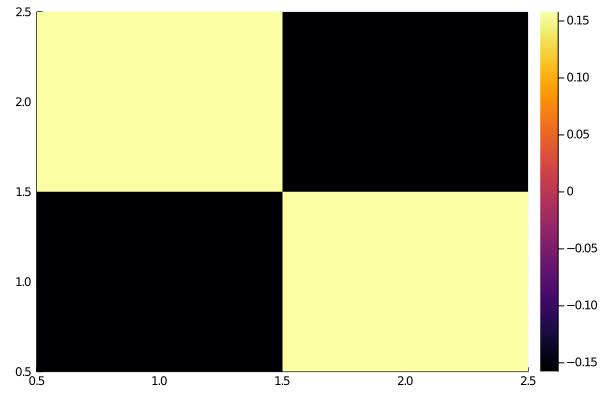

In [14]:
heatmap(real.(expectation_value(gs_chan,sz)))